# Team Project - Kickstarter Project

* Author: Julia Hammerer, Vanessa Mai
* Last Update: 15.06.2018



## Project Description
In this project we will look at a list of Crowdfunding Projects pulled from the Kickstarter website in 2018. Analysis will be mainly Data Explorations on the Project and may include (but not exclusively)
* compare successful and failed projects per country, and category
* look at size/funding amount of projects
* what's the value of successful projects, are there differences to failed ones?
* time series analysis 
* how much do people donate to projects in average

Here we will import all packages required for our analysis

In [1]:
import pandas as pd
from datetime import datetime

Then first of all we import our csv file as a pandas dataframe


In [3]:
ks_raw=pd.read_csv("ks-projects-201801.csv")

In [4]:
ks_raw

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


When looking at the data we see that there are several fields with amounts (=pledged). The fields "pledged" and "goal" are in the original currency. There is also "usd pledged", usd_pledged_real", "uds_goal_real". "usd pledged" is the amount converted to us-dollar by Kickstarter. According to the description from Kaggle "usd_pledged_real" and "usd_goal_real" are converted using fixer.io by tonyplaysguitar. 
We'll use these fields, as this also have the "goal" in US-Dollars and we remove the other columns


In [5]:
# remove unused columns, we don't need name and id, and the mentioned amounts
# we also do not need currency, as we have everything in US-Dollar
ks=ks_raw.drop(["ID", "name", "goal", "pledged", "usd pledged", "currency"], axis=1)

# we take a look at the datatypes, to look if we need to convert any fields to the appropriate data type
ks.dtypes 

category             object
main_category        object
deadline             object
launched             object
state                object
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

We see that all the fields, that we need in a numeric form, are already automatically detected by python as numeric. 
However, to use the dates correctly, we need to convert launched and deadline into a datetime-datatype

In [6]:
ks["launched"] = pd.to_datetime(ks["launched"], infer_datetime_format=True)
ks["deadline"] = pd.to_datetime(ks["deadline"], infer_datetime_format=True)

In [7]:
# check for open projects
closed=ks["deadline"]>ks["launched"]
closed.value_counts()

True    378661
dtype: int64

We see that we only have closed projects here. As a prospect, we could include open projects and do a prediction on whether a project will be successful or not. Next step is to look at the data more closely and see some basic information on the data. For this we use the package pandas-profiling. See documenation [here](https://github.com/pandas-profiling/pandas-profiling)


In [8]:
import pandas_profiling

In [9]:
pandas_profiling.ProfileReport(ks)

Number of variables,9
Number of observations,378661
Total Missing (%),0.0%
Total size in memory,26.0 MiB
Average record size in memory,72.0 B
Numeric,3
Categorical,4
Boolean,0
Date,2
Text (Unique),0
Rejected,0


So we have a basic summary first. The data seems to be complete, there are no missing values, so we do not have to deal with that. However, if we look closely at **"launched"**, which is the launch-day of a product, we can see that there are some in 1970. These might be missing values, so we have to think about what to do with that. As we have plenty records (~380 000) and the number of those observations are relatively low, it is enough if we just remove those observations

Another thing is, that the cardinality of **"category"** is very high, meaning there are many different values. If in the end, the number of observations per category is too small, it might not make much sense to explore them further. We will elaborate on that later more closely.

The **countries** are only displayed with their country code. We need to convert them to proper country names for better readability, later on also possibly some geocoding, and thus using maps for visualizations and such things. We will also elaborate on that later.

Pandas_Profiling also provides a really quick Correlation Analysis. We can see a high positive correlation between backers und pledged amount, which makes perfect sense, so this does not give us particularly interesting information. In fact, it is more interesting to see the average amount that backers give for the projects. Thus, we'll look into this later.

In [11]:
## remove the rows with launched in 1970
ks = ks[(ks["launched"].dt.year > 1970)]

In [12]:
# read in a mapping file for countries
country_mapping=pd.read_csv("country.csv")

In [15]:
country_mapping

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS
5,Andorra,AD
6,Angola,AO
7,Anguilla,AI
8,Antarctica,AQ
9,Antigua and Barbuda,AG


In [30]:
# we'll do a left outer join, with our Kickstarter-Projectlist being left
ks= pd.merge(ks,country_mapping, how="left", left_on="country", right_on="Code" )

# we can see that the names are now properly written out
# but we'll need to remove the joining columns and rename the Country column from "Name" to "Country"
ks= ks.drop(["country", "Code"], axis=1)
ks=ks.rename(columns={"Name": "Country"})
ks.tail()

,category,main_category,deadline,launched,state,backers,usd_pledged_real,usd_goal_real,Country
378649,Documentary,Film & Video,2014-10-17,2014-09-17 02:35:30,canceled,1,25.0,50000.0,United States
378650,Narrative Film,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,155.0,1500.0,United States
378651,Narrative Film,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,20.0,15000.0,United States
378652,Technology,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,200.0,15000.0,United States
378653,Performance Art,Art,2011-08-16,2011-07-19 09:07:47,failed,17,524.0,2000.0,United States


## Distributions

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### First we take a look at the distribution of the status of the Projects


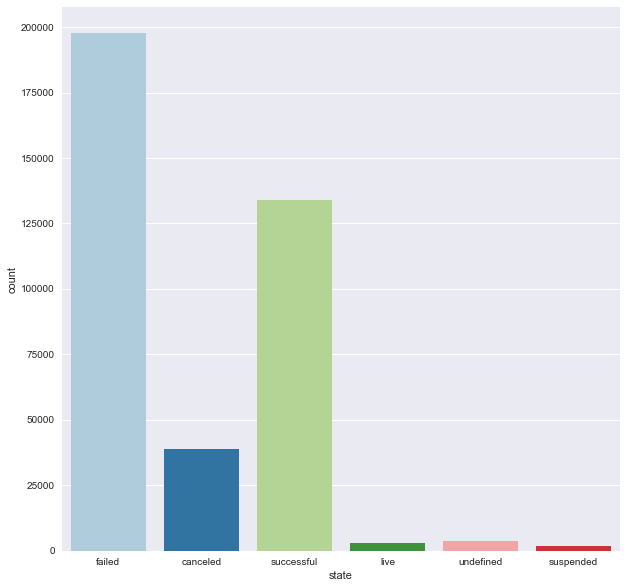

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.countplot(x="state",data=ks, ax=ax,palette="Paired")


#### We can see that most Projects have failed. The values "live", "undefined" and "suspended" have the least values and their status is not clear. So these values will be removed in the next step. We concentrate on the more meaningful values "failed", "canceled" and "successful"

#### Removing Rows

In [6]:
ks= ks[ks.state != "live"]
ks= ks[ks.state != "undefined"]
ks= ks[ks.state != "suspended"]

#### Distribution of the Main Category

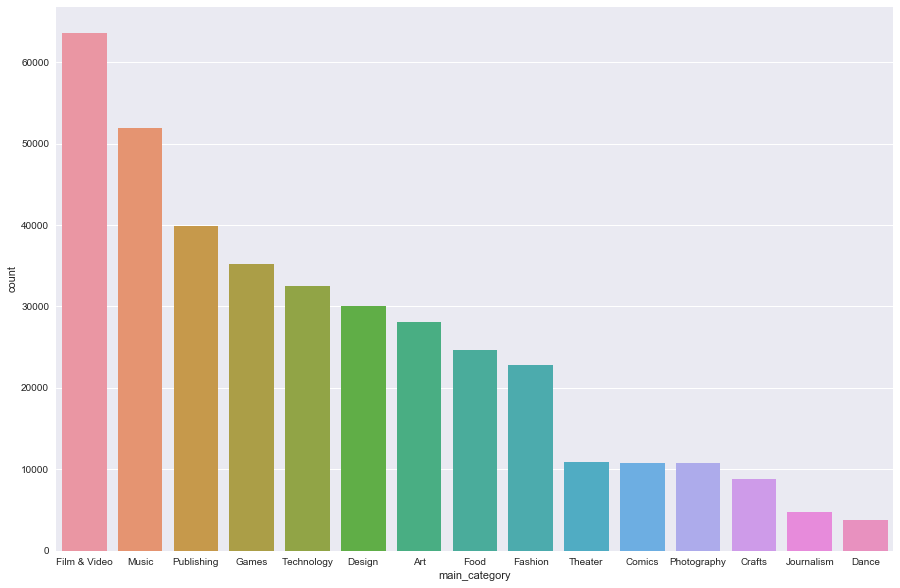

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="main_category",data=ks, ax=ax, order = ks['main_category'].value_counts().index)

#### We have a deeper look at the distribution of categories and main categories

In [63]:
ks.groupby("main_category")["category"].value_counts()


main_category  category         
Art            Art                  8253
               Painting             3294
               Illustration         3175
               Public Art           3077
               Mixed Media          2757
               Performance Art      2154
               Sculpture            1810
               Digital Art          1346
               Conceptual Art       1030
               Installations         482
               Ceramics              305
               Textiles              276
               Video Art             194
Comics         Comics               4996
               Comic Books          2743
               Graphic Novels       1864
               Webcomics             648
               Anthologies           405
               Events                163
Crafts         Crafts               4664
               DIY                  1173
               Woodworking          1167
               Candles               429
               Printing 

#### How is the distribution of failed,canceld or successful Projects in each category?

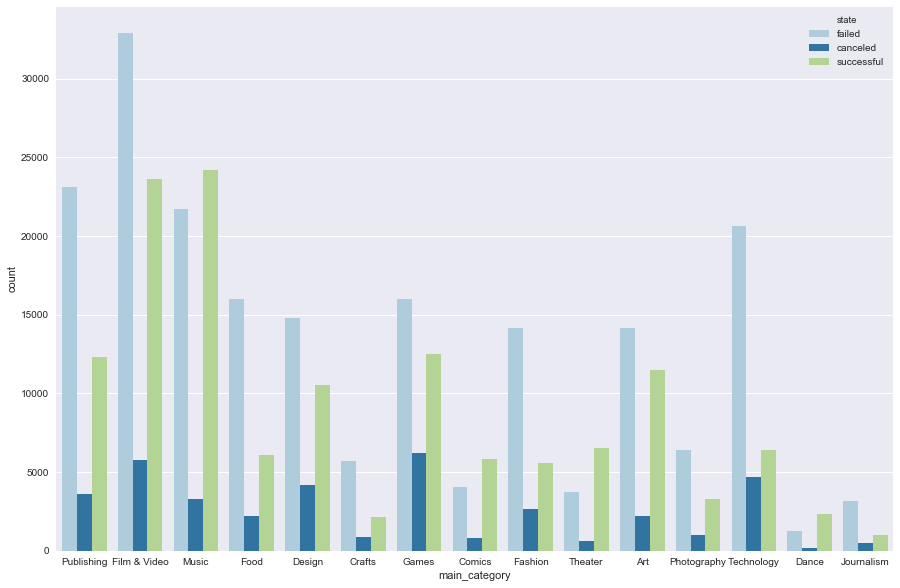

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="main_category",hue="state",data=ks, ax=ax, palette="Paired")

#### How many entries in the dataset are from which country?

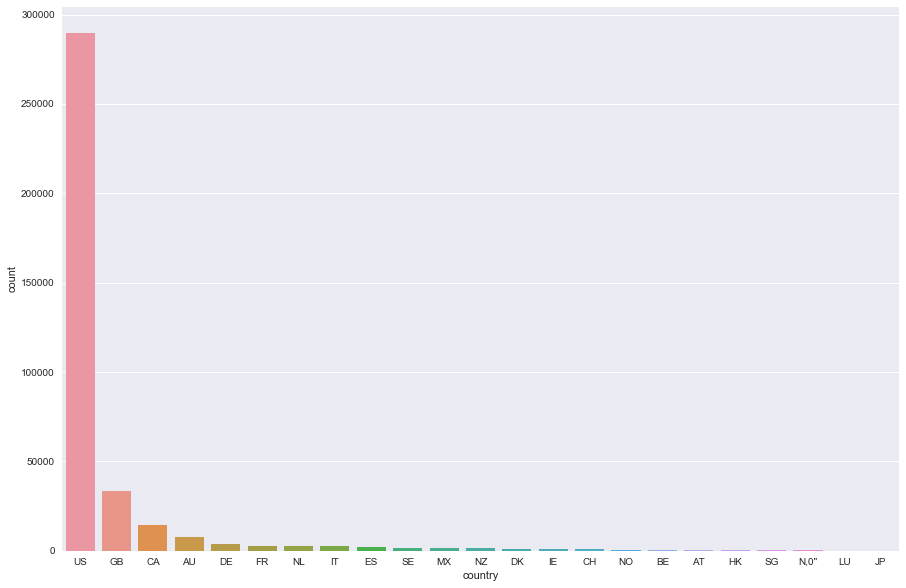

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="country",data=ks,order = ks['country'].value_counts().index,ax=ax)

#### Distribution of the Project state across the countries

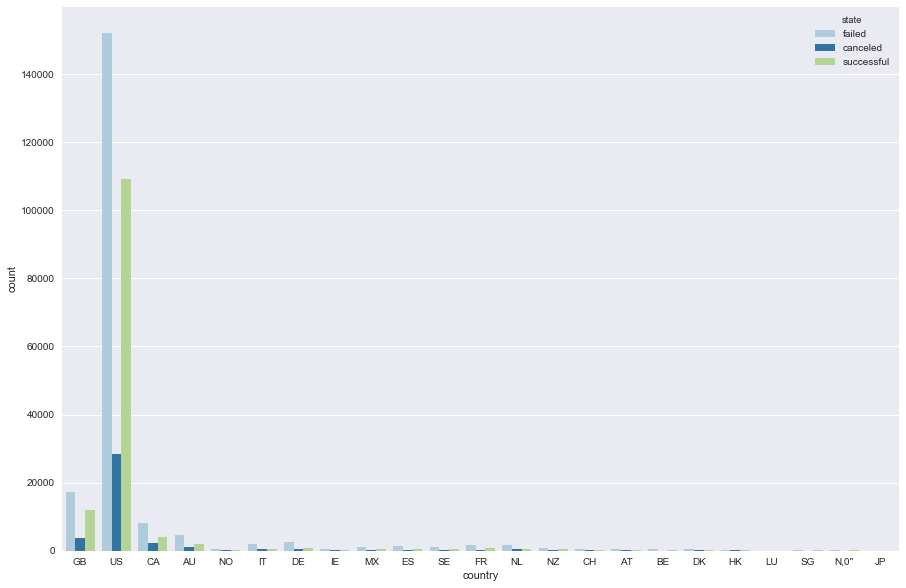

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.countplot(x="country",hue="state",data=ks, ax=ax, palette="Paired")

#### How many backers do the projects have in each country?

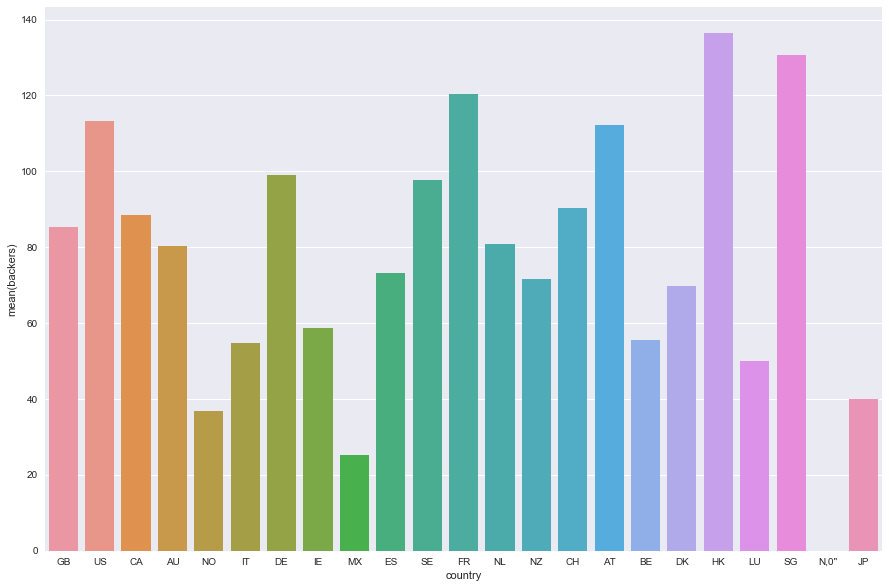

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.barplot(x="country",y="backers",data=ks,ci=None, ax=ax)
plt.show()

In [8]:
print("Minimal goal value:", ks["usd_goal_real"].min())
print("Mean goal value:", ks["usd_goal_real"].mean())
print("Maximum goal value:", ks["usd_goal_real"].max())

Minimal goal value: 0.01
Mean goal value: 45076.37631279465
Maximum goal value: 166361390.71
